# Diplodatos Kaggle Competition

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from utils import display_markdown

In [2]:
def transform_data(train_data_fname, test_data_fname):
    df_train = pd.read_csv(train_data_fname)
    df_train['is_train_set'] = 1
    df_test = pd.read_csv(test_data_fname)
    df_test['is_train_set'] = 0

    # we  get the TripType for the train set. To do that, we group by VisitNumber and
    # then we get the max (or min or avg)
    y = df_train.groupby(["VisitNumber", "Weekday"], as_index=False).max().TripType

    # we remove the TripType now, and concat training and testing data
    # the concat is done so that we have the same columns for both datasets
    # after one-hot encoding
    df_train = df_train.drop("TripType", axis=1)
    df = pd.concat([df_train, df_test])
    
    # the next three operations are the ones we have just presented in the previous lines
    
    # drop the columns we won't use (it may be good to use them somehow)
    df = df.drop(["Upc", "FinelineNumber"], axis=1)

    # one-hot encoding for the DepartmentDescription
    df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)

    # now we add the groupby values
    df = df.groupby(["VisitNumber", "Weekday"], as_index=False).sum()
    
    # we do one-hot encoding for the Weekday
    df = pd.get_dummies(df, columns=["Weekday"], dummy_na=True)

    # get train and test back
    df_train = df[df.is_train_set != 0]
    df_test = df[df.is_train_set == 0]
    
    X = df_train.drop(["is_train_set"], axis=1)
    yy = None
    XX = df_test.drop(["is_train_set"], axis=1)
    visit_n_test = XX.VisitNumber

    # we exclude visit number; it's just an index, it messes up all the
    # training (added by Javi).
    X = X.drop(columns=['VisitNumber'])
    XX = XX.drop(columns=['VisitNumber'])
    
    return X, y, visit_n_test, XX, yy

Load the data...

In [3]:
X, y, visit_n_test, XX, yy = transform_data("./data/train.csv", "./data/test.csv")

Create the model and evaluate it

In [4]:
# split training dataset into train and "validation" 
# (we won't be using validation set in this example, because of the cross-validation;
# but it could be useful for you depending on your approach)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

X_train

,ScanCount,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,...,DepartmentDescription_WIRELESS,DepartmentDescription_nan,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Weekday_nan
81954,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
32578,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
86578,5,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
85079,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9788,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52950,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8809,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
78302,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1229,8,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [5]:
# results dataframe is used to store the computed results
results = pd.DataFrame(columns=('clf', 'best_acc'))

In [6]:
"""
# Original:
model_param = {
    'criterion': ('gini', 'entropy'),
    'min_samples_leaf': (1, 2, 5),
    'min_samples_split': (2, 3, 5, 10, 50, 100)
}
model = DecisionTreeClassifier(random_state=42)
"""

"""
Best models so far (from better to worse):

MLPClassifier(
    alpha=0.03,
    beta_1=0.8,
    beta_2=0.99999,
    hidden_layer_sizes=(96,),
    max_iter=300,
    n_iter_no_change=30,
    random_state=42
)
MLPClassifier(
    alpha=0.03,
    hidden_layer_sizes=(96,),
    max_iter=300,
    n_iter_no_change=30,
    random_state=42
)
MLPClassifier(
    alpha=0.02,
    hidden_layer_sizes=(64,),
    max_iter=300,
    random_state=42
)
DecisionTreeClassifier(
    random_state=42,
    min_samples_leaf=5,
    min_samples_split=101,
    max_depth=59,
    class_weight={999: 0.49}
)
"""

model_params = {
    'beta_1': (0.8,),
    'beta_2': (0.99999,),
}
model = MLPClassifier(random_state=42,
                      verbose=True,
                      max_iter=300,
                      alpha=0.03,
                      n_iter_no_change=30,
                      hidden_layer_sizes=(96,))

search = GridSearchCV(model,
                      model_params,
                      cv=3,
                      # n_jobs=-1,  # Use all processors.
                      scoring='accuracy',
                      verbose=1)  # scoring='balanced_accuracy'

search.fit(X_train, y_train)

best_found_clf = search.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Iteration 1, loss = 2.61309642
Iteration 2, loss = 1.50575373
Iteration 3, loss = 1.25339794
Iteration 4, loss = 1.15990872
Iteration 5, loss = 1.11010052
Iteration 6, loss = 1.07714854
Iteration 7, loss = 1.05270407
Iteration 8, loss = 1.03491592
Iteration 9, loss = 1.01832212
Iteration 10, loss = 1.00731881
Iteration 11, loss = 0.99616158
Iteration 12, loss = 0.98578023
Iteration 13, loss = 0.97817940
Iteration 14, loss = 0.97035809
Iteration 15, loss = 0.96392514
Iteration 16, loss = 0.95772222
Iteration 17, loss = 0.95085115
Iteration 18, loss = 0.94399899
Iteration 19, loss = 0.93931794
Iteration 20, loss = 0.93593474
Iteration 21, loss = 0.93126724
Iteration 22, loss = 0.92608372
Iteration 23, loss = 0.92182880
Iteration 24, loss = 0.91840470
Iteration 25, loss = 0.91456487
Iteration 26, loss = 0.91189997
Iteration 27, loss = 0.90911434
Iteration 28, loss = 0.90614362
Iteration 29, loss = 0.90326771
Iteration 30, loss = 0.90064052
Iteration 31, loss = 0.89715576
Iteration 32, los

/home/javiergallo/miniconda3/envs/diplodatos/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 2.61742848
Iteration 2, loss = 1.50757027
Iteration 3, loss = 1.26029338
Iteration 4, loss = 1.16518973
Iteration 5, loss = 1.11578492
Iteration 6, loss = 1.08147117
Iteration 7, loss = 1.05700553
Iteration 8, loss = 1.03784213
Iteration 9, loss = 1.02059157
Iteration 10, loss = 1.00922082
Iteration 11, loss = 0.99753320
Iteration 12, loss = 0.98669686
Iteration 13, loss = 0.97776790
Iteration 14, loss = 0.97025752
Iteration 15, loss = 0.96323410
Iteration 16, loss = 0.95756052
Iteration 17, loss = 0.95060418
Iteration 18, loss = 0.94510227
Iteration 19, loss = 0.93973074
Iteration 20, loss = 0.93515922
Iteration 21, loss = 0.93182112
Iteration 22, loss = 0.92679950
Iteration 23, loss = 0.92260554
Iteration 24, loss = 0.92002115
Iteration 25, loss = 0.91615432
Iteration 26, loss = 0.91306355
Iteration 27, loss = 0.91051500
Iteration 28, loss = 0.90743691
Iteration 29, loss = 0.90464131
Iteration 30, loss = 0.90188324
Iteration 31, loss = 0.89947192
Iteration 32, los

/home/javiergallo/miniconda3/envs/diplodatos/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 2.61162668
Iteration 2, loss = 1.50725433
Iteration 3, loss = 1.25420766
Iteration 4, loss = 1.16089924
Iteration 5, loss = 1.10776228
Iteration 6, loss = 1.07353982
Iteration 7, loss = 1.04865884
Iteration 8, loss = 1.02852855
Iteration 9, loss = 1.01260724
Iteration 10, loss = 1.00087157
Iteration 11, loss = 0.98973708
Iteration 12, loss = 0.98029392
Iteration 13, loss = 0.97172212
Iteration 14, loss = 0.96460516
Iteration 15, loss = 0.95858023
Iteration 16, loss = 0.95016627
Iteration 17, loss = 0.94490350
Iteration 18, loss = 0.93909660
Iteration 19, loss = 0.93475591
Iteration 20, loss = 0.93040314
Iteration 21, loss = 0.92460986
Iteration 22, loss = 0.92072016
Iteration 23, loss = 0.91740571
Iteration 24, loss = 0.91312342
Iteration 25, loss = 0.91023966
Iteration 26, loss = 0.90713775
Iteration 27, loss = 0.90514209
Iteration 28, loss = 0.90200687
Iteration 29, loss = 0.89923559
Iteration 30, loss = 0.89709592
Iteration 31, loss = 0.89344736
Iteration 32, los

/home/javiergallo/miniconda3/envs/diplodatos/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.5min finished


Iteration 1, loss = 2.28674052
Iteration 2, loss = 1.31093222
Iteration 3, loss = 1.15790133
Iteration 4, loss = 1.09663572
Iteration 5, loss = 1.05953026
Iteration 6, loss = 1.03445582
Iteration 7, loss = 1.01706251
Iteration 8, loss = 1.00225217
Iteration 9, loss = 0.98997892
Iteration 10, loss = 0.97956292
Iteration 11, loss = 0.97005799
Iteration 12, loss = 0.96265076
Iteration 13, loss = 0.95459246
Iteration 14, loss = 0.94900034
Iteration 15, loss = 0.94254913
Iteration 16, loss = 0.93711596
Iteration 17, loss = 0.93326171
Iteration 18, loss = 0.92768156
Iteration 19, loss = 0.92412697
Iteration 20, loss = 0.92019768
Iteration 21, loss = 0.91722915
Iteration 22, loss = 0.91399503
Iteration 23, loss = 0.91063932
Iteration 24, loss = 0.90832256
Iteration 25, loss = 0.90624154
Iteration 26, loss = 0.90331874
Iteration 27, loss = 0.90168567
Iteration 28, loss = 0.89933657
Iteration 29, loss = 0.89743939
Iteration 30, loss = 0.89601150
Iteration 31, loss = 0.89432808
Iteration 32, los

/home/javiergallo/miniconda3/envs/diplodatos/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


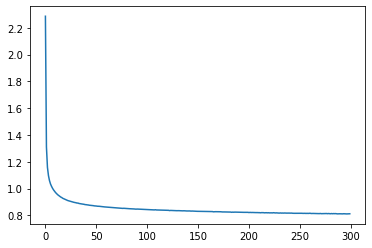

In [7]:
plt.plot(best_found_clf.loss_curve_);

In [8]:
display_markdown('**Best classifier found**:')
print(best_found_clf)
display_markdown('**Accuracy**: {}'.format(search.best_score_))

**Best classifier found**:

MLPClassifier(alpha=0.03, beta_1=0.8, beta_2=0.99999, hidden_layer_sizes=(96,),
              max_iter=300, n_iter_no_change=30, random_state=42, verbose=True)


**Accuracy**: 0.6916879795396419

In [9]:
results = results.append(
    {'clf': best_found_clf, 'best_acc': search.best_score_},
    ignore_index=True
)

In [10]:
results

,clf,best_acc
0,"MLPClassifier(alpha=0.03, beta_1=0.8, beta_2=0...",0.691688


In [11]:
best_clf_idx = results['best_acc'].idxmax()
best_clf = results.loc[best_clf_idx]['clf']
best_acc = results.loc[best_clf_idx]['best_acc']
display_markdown('**The best classifier so far is:**')
print(best_clf)
display_markdown('**Accuracy**: {}'.format(search.best_score_))

**The best classifier so far is:**

MLPClassifier(alpha=0.03, beta_1=0.8, beta_2=0.99999, hidden_layer_sizes=(96,),
              max_iter=300, n_iter_no_change=30, random_state=42, verbose=True)


**Accuracy**: 0.6916879795396419

**And finally**, we predict the unknown label for the testing set

In [12]:
X.shape, XX.shape

((67029, 78), (28645, 78))

In [13]:
yy = best_clf.predict(XX)

The last thing we do is generating a file that should be *submitted* on kaggle

In [14]:
submission = pd.DataFrame(list(zip(visit_n_test, yy)), columns=["VisitNumber", "TripType"])
submission.to_csv('./data/submission.csv', header=True, index=False)